In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'SVM(C=10.0)特徴量ミニマム'
notebook_name = '045'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

045_submission.csv 045


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', StandardScaler(), discrete_features),
            ('categorical', 'passthrough', categorical_features)
        ]
    )
    clf = SVC(random_state=SEED, C=10.0, class_weight='balanced')
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
for c in categorical_features:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

categorical_features_1hot = []
for c in categorical_features:
    categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
print(categorical_features_1hot)

features = discrete_features + categorical_features_1hot

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['B', 'O', 'numRunners', 'totalPitchingCount', 'S', 'inningNo']
['b1_1', 'b2_1', 'b3_1', 'batterID_0', 'batterID_2', 'batterID_5', 'batterID_9', 'batterID_11', 'batterID_12', 'batterID_15', 'batterID_18', 'batterID_19', 'batterID_21', 'batterID_22', 'batterID_26', 'batterID_27', 'batterID_28', 'batterID_29', 'batterID_31', 'batterID_34', 'batterID_36', 'batterID_37', 'batterID_39', 'batterID_42', 'batterID_45', 'batterID_47', 'batterID_50', 'batterID_55', 'batterID_56', 'batterID_58', 'batterID_60', 'batterID_67', 'batterID_70', 'batterID_72', 'batterID_73', 'batterID_75', 'batterID_80', 'batterID_82', 'batterID_84', 'batterID_85', 'batterID_87', 'batterID_89', 'batterID_91', 'batterID_98', 'batterID_102', 'batterID_103', 'batterID_105', 'batterID_106', 'batterID_111', 'batterID_112', 'batterID_114', 'batterID_117', 'batterID_118', 'b

In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features_1hot)
    clf.fit(X_train, y_train.values)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[3203  645  641  376  135   41    3   22]
 [ 306 2894  360  125   41   13    0    7]
 [ 138  115 1902  164   59    9    0    6]
 [  13   13   21 1660    2    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[445 314 269 160  57  12   1   9]
 [254 340 208  97  21   8   0   8]
 [160 135 185  85  23   6   0   5]
 [141  89 134  54   7   2   0   0]
 [ 45  25  38  19   8   0   0   0]
 [ 15  10   6   6   0   0   0   0]
 [  2   0   0   1   0   0   0   0]
 [  5   7   9   3   0   0   0   0]]

**********Confusion matrix for train set (Fold 2)**********
[[3201  661  628  385  134   37    1   19]
 [ 313 2841  385  147   37   15    0    8]
 [ 133  130 1887  173   57    8    0    5]
 [  14   13   19 1661    2    0    0    0]
 [   0    0    

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.801404,0.145254
std,0.005629,0.002287
min,0.797553,0.143510
25%,0.798472,0.144020
50%,0.799231,0.144467
75%,0.800472,0.145057
max,0.811289,0.149216


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,0,0,1
2,2,0,0,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,5.244130,5.260904,7.292690,3.117119,5.225728,0.717300,-0.280525,1.719709,27446,1
1,5.277643,4.231648,7.291065,6.268120,2.781837,0.710022,-0.264924,1.715644,113,1
2,5.290095,6.293502,7.294461,4.109329,2.719435,0.710474,-0.257391,1.709261,4479,1
3,4.280179,6.300197,7.289612,5.247310,2.756153,0.706670,-0.295285,1.714209,29080,1
4,5.282323,6.265293,7.279339,4.268063,2.761161,0.706179,-0.266220,1.724300,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,5.286138,4.268461,7.286148,6.275267,2.818918,1.725758,-0.298757,0.710903,24272,5
33804,5.270723,4.256226,7.283418,6.278001,2.821760,1.778270,-0.299765,0.712435,29106,5
33805,5.250397,4.179066,6.277306,7.297037,3.098582,0.731671,-0.307979,1.802279,20679,5
33806,7.301934,2.777547,4.252013,6.290451,5.237192,1.724246,-0.294290,0.705326,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,26.276390,29.368995,36.434064,20.115164,18.384494,8.636561,-1.483277,3.653184
1,1,32.467835,33.483204,21.225474,28.354905,11.660648,10.853437,-1.493382,3.523865
2,2,18.817204,26.140298,31.373208,36.385407,17.803894,4.621788,-1.456070,7.794773
3,3,32.484445,35.501286,25.983086,20.262093,12.790818,9.836483,-1.511693,3.689614
4,4,31.471058,36.504883,18.779039,22.781178,19.424709,7.614026,-1.496204,4.602424
...,...,...,...,...,...,...,...,...,...
33803,33803,36.507084,22.174345,31.369706,25.285107,15.517088,8.718857,-1.491936,3.503597
33804,33804,29.391446,36.481058,21.194076,24.184507,19.964694,4.600899,-1.533073,7.688712
33805,33805,35.456862,29.438063,23.304967,27.324138,13.891369,3.570166,-1.514220,8.727783
33806,33806,25.261970,30.346513,30.313668,29.303675,15.119558,5.646478,-1.446324,6.680135


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,2
1,1,1
2,2,3
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,0
33806,33806,1


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.327733
1    0.369972
2    0.136299
3    0.152479
4    0.012453
5    0.000739
7    0.000325
Name: y, dtype: float64

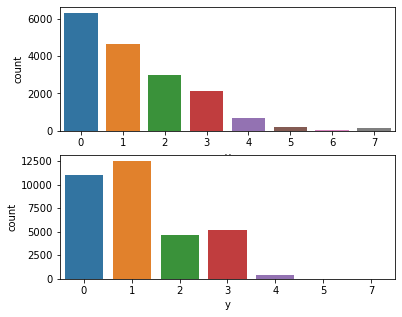

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.8014035414695091, 0.14525403537000559)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"045_submission.csv","Stratified-Kfold(K=5)","0.801404","0.145254","","SVM(C=10.0)特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.3 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [21]:
imp_df

""


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
